In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import sys
sys.path.append("..")
from src.data_loader import load_csv_data
from src.feature_engineering import rolling_correlation, overall_correlation
from src.feature_engineering import hedge_ratio, hurst_exponent

In [2]:
# Load price data
ticker1 = 'SPY'
ticker2 = 'IVV'

prices, price1, price2 = load_csv_data(f"../data_raw/prices.csv", ticker1, ticker2)
print(f"Data points: {len(price1)}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")

Data points: 1508
Date range: 2020-01-02 to 2025-12-31


## 1. Validate Trading Strategy Hypothesis

Before feature engineering, we'll verify:
- **Hurst Exponent**: Prove mean reversion behavior
- **Cointegration**: Prove long-run equilibrium relationship
- **Correlation**: Prove the stocks move together

### 1.1 Correlation Analysis

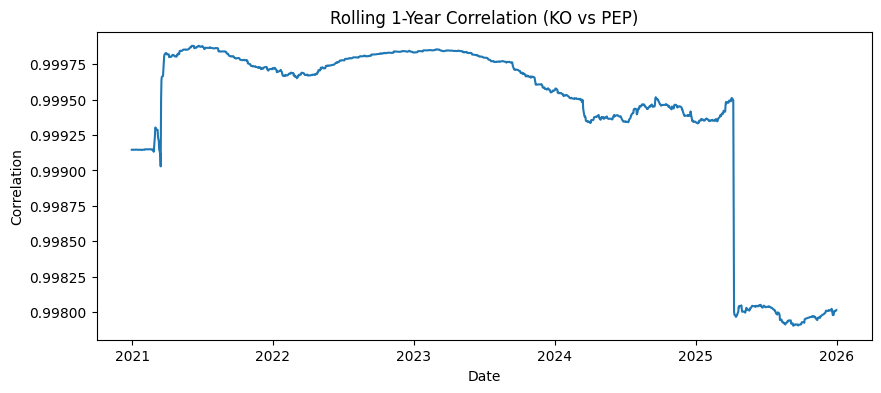

Overall correlation (KO vs PEP): 0.9990
The rolling window used is 252 days.
Data points: 1508
Date range: 2020-01-02 to 2025-12-31


In [3]:
# First we compute the correlation
# Log returns:
returns = np.log(prices).diff().dropna()
return1 = returns[ticker1].to_numpy()
return2 = returns[ticker2].to_numpy()
dates = returns.index
window = 252

# Compute rolling correlation
data_rolling_correlation = rolling_correlation(return1, return2, window)
rolling_corr_series = pd.Series(data_rolling_correlation, index=dates, name="rolling_corr_252d")
rolling_corr_series.tail()

# Plotting the data of correlation
plt.figure(figsize=(10, 4))
plt.plot(rolling_corr_series.index, rolling_corr_series.values)
plt.title("Rolling 1-Year Correlation (KO vs PEP)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.show()

# Compute the overall correlation
corr = overall_correlation(return1, return2)
print(f"Overall correlation (KO vs PEP): {corr:.4f}")
print(f"The rolling window used is {window} days.")
print(f"Data points: {len(price1)}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")


### 1.2 Cointegration Test
Tests if stocks have a long-run equilibrium relationship (essential for pairs trading)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
1508 1508 (1508, 2)
True


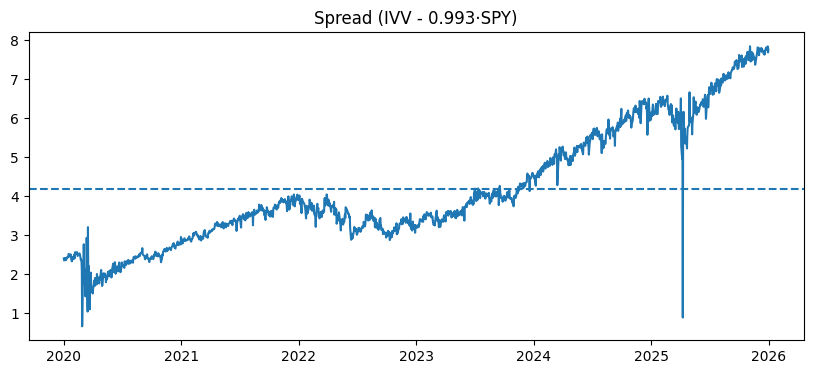

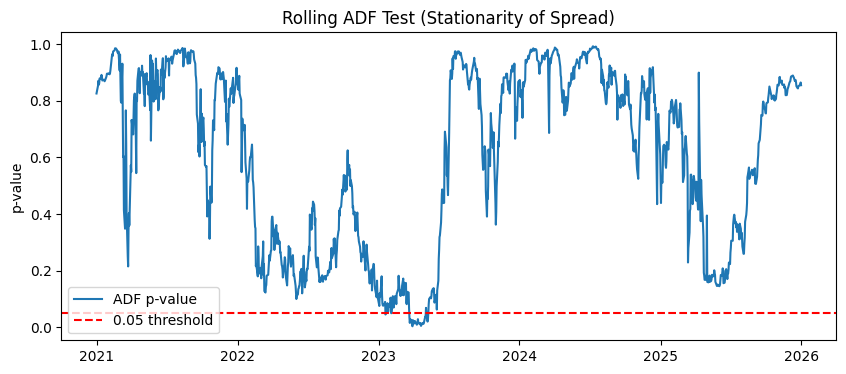

In [4]:
# Then we compute the Cointegration test


# keep only these two columns, then drop rows where either is missing
prices = prices[[ticker1, ticker2]].dropna()

# 2) Keep as pandas Series (important)
price1 = prices[ticker1]
price2 = prices[ticker2]

# sanity checks (run these!)
print(type(price1), type(price2))
print(len(price1), len(price2), prices.shape)
print(price1.index.equals(price2.index))  # should be True

beta = hedge_ratio(price2, price1)
spread = price2 - beta * price1  # this is a pandas Series with the same index as prices

plt.figure(figsize=(10,4))
plt.plot(spread.index, spread.values)
plt.axhline(spread.mean(), linestyle="--")
plt.title(f"Spread ({ticker2} - {beta:.3f}·{ticker1})")
plt.show()

rolling_pvals = []

for i in range(window, len(spread)):
    spread_window = spread.iloc[i-window:i]
    pval = adfuller(spread_window)[1]
    rolling_pvals.append(pval)

rolling_pvals = pd.Series(
    rolling_pvals,
    index=spread.index[window:]
)

plt.figure(figsize=(10,4))
plt.plot(rolling_pvals.index, rolling_pvals.values, label="ADF p-value")
plt.axhline(0.05, color="red", linestyle="--", label="0.05 threshold")
plt.title("Rolling ADF Test (Stationarity of Spread)")
plt.ylabel("p-value")
plt.legend()
plt.show()





### 1.3 Rolling Z-score


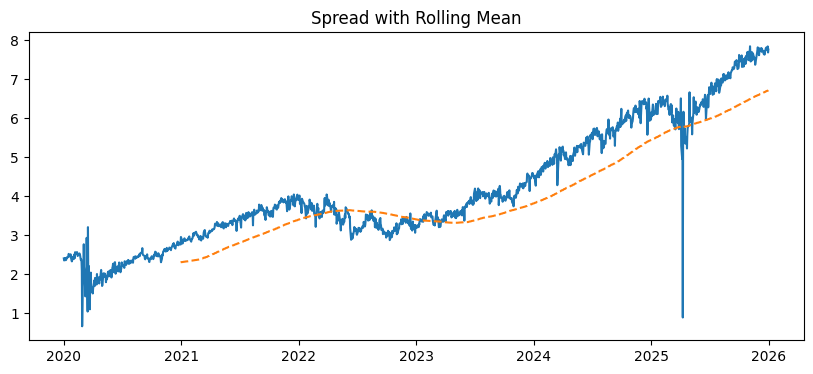

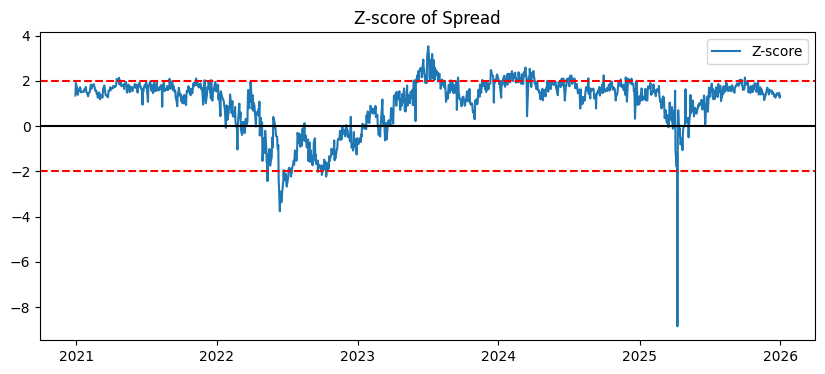

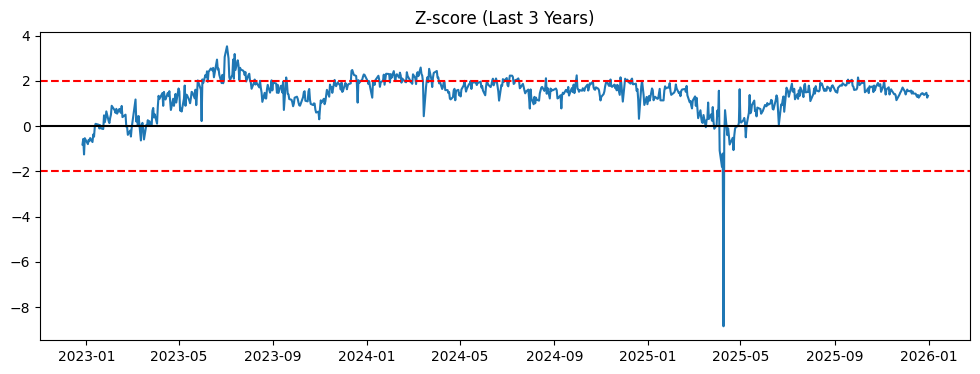

(np.float64(-8.85367297158323), np.float64(3.5315421568992287))

In [5]:
window = 252
spread_mean = spread.rolling(window).mean()
spread_std  = spread.rolling(window).std()
z_score = (spread - spread_mean) / spread_std # pandas Series

plt.figure(figsize=(10,4))
plt.plot(spread.index, spread.values)
plt.plot(spread_mean.index, spread_mean.values, linestyle="--")
plt.title("Spread with Rolling Mean")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(z_score.index, z_score.values, label="Z-score")
plt.axhline( 2, color="red", linestyle="--")
plt.axhline(-2, color="red", linestyle="--")
plt.axhline( 0, color="black")
plt.title("Z-score of Spread")
plt.legend()
plt.show()

z_recent = z_score.dropna().tail(252 * 3)  # last 3 years

plt.figure(figsize=(12,4))
plt.plot(z_recent.index, z_recent.values)
plt.axhline( 2, color="red", linestyle="--")
plt.axhline(-2, color="red", linestyle="--")
plt.axhline( 0, color="black")
plt.title("Z-score (Last 3 Years)")
plt.show()

(z_score.abs() > 2).sum()
z_score.min(), z_score.max()


### 1.4 Hurst Exponent Analysis
Mean reversion hypothesis: Hurst < 0.5

Hurst exponent of the spread: 0.2253


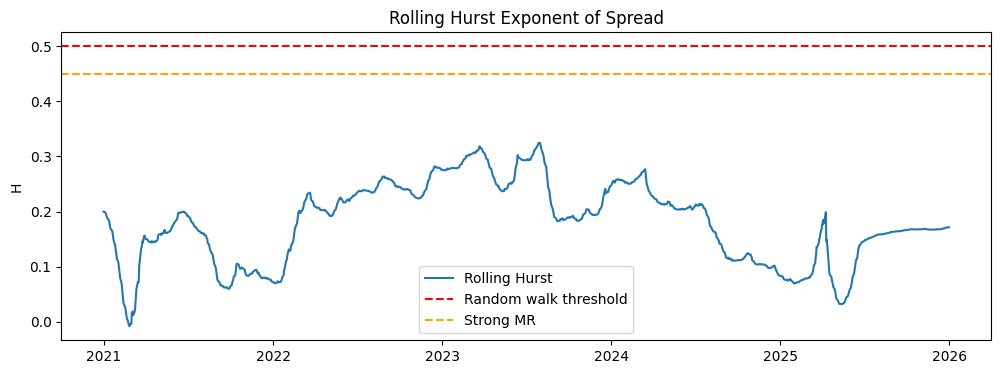

In [6]:
# compute the Hurst exponent of the spread
H_full = hurst_exponent(spread.values, max_lag=100)
print(f"Hurst exponent of the spread: {H_full:.4f}")

# compute the Hurst exponent of the rolling spread
window = 252
rolling_H = []

for i in range(window, len(spread)):
    spread_window = spread.iloc[i-window:i]
    H = hurst_exponent(spread_window.values, max_lag=50)
    rolling_H.append(H)

rolling_H = np.array(rolling_H)
rolling_H_series = pd.Series(
    rolling_H,
    index=spread.index[window:]
)

# plotting the rolling Hurst exponent
plt.figure(figsize=(12,4))
plt.plot(rolling_H_series.index, rolling_H_series.values, label="Rolling Hurst")
plt.axhline(0.5, color="red", linestyle="--", label="Random walk threshold")
plt.axhline(0.45, color="orange", linestyle="--", label="Strong MR")
plt.title("Rolling Hurst Exponent of Spread")
plt.ylabel("H")
plt.legend()
plt.show()


## 2. Features Engineering

Saved: ../data_processed/features.csv
Rows, Cols: (1256, 16)


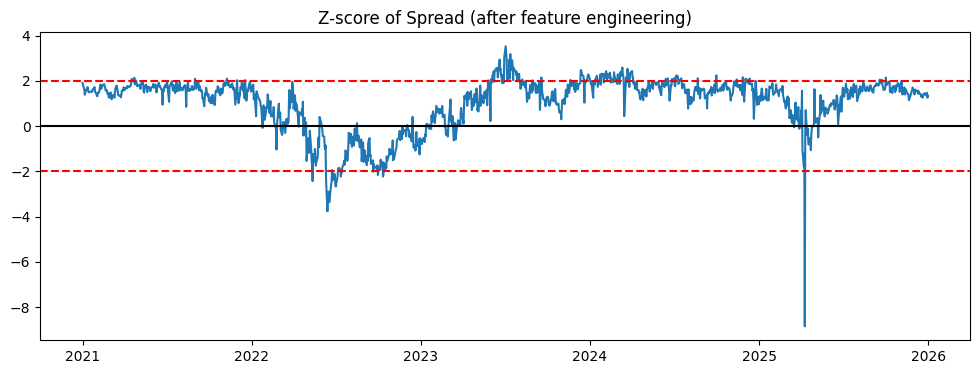

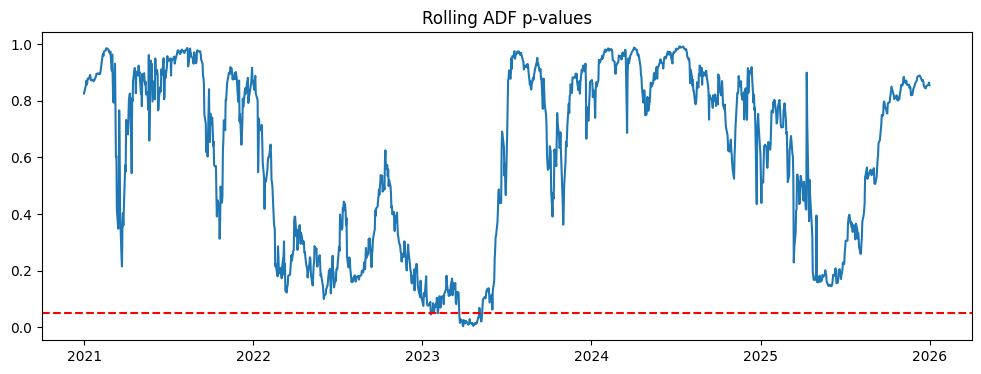

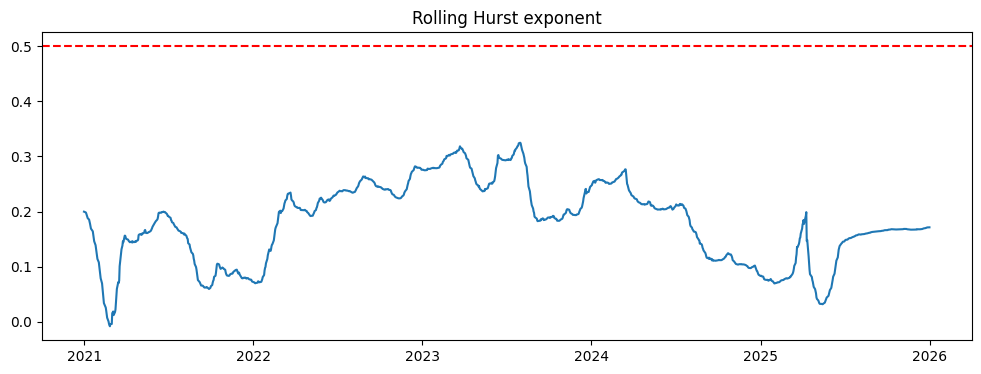

In [7]:
features = pd.DataFrame({
    "price1": price1,
    "price2": price2,
    "beta": beta,  
    "spread": spread,
    "spread_mean": spread_mean,
    "spread_std": spread_std,
    "z_score": z_score,
    "spread_change": spread.diff(),
    "spread_vol_20": spread.rolling(20).std(),
    "ret1": price1.pct_change(),
    "ret2": price2.pct_change(),
})

rolling_pvals.name = f"adf_p_{window}"
rolling_H_series.name = f"hurst_{window}"
# Join rolling diagnostics (align on index)
features = features.join(rolling_pvals, how="left")
features = features.join(rolling_H_series, how="left")

# Regime indicators 
# 2 = strong Mean reversion
features["adf_stationary"] = (features[f"adf_p_{window}"] < 0.05).astype(int)
features["hurst_mr"] = (features[f"hurst_{window}"] < 0.5).astype(int)
features["regime_score"] = features["adf_stationary"] + features["hurst_mr"]  

# Drop rows with NaNs created by rolling/returns (now safe to save)
features = features.dropna()

# -----------------------------
# Save processed features for next notebooks
# -----------------------------
features.to_csv("../data_processed/features.csv")
print("Saved:", "../data_processed/features.csv")
print("Rows, Cols:", features.shape)

# -----------------------------
# Optional quick plots (sanity check)
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(features.index, features["z_score"])
plt.axhline(2, color="red", linestyle="--")
plt.axhline(-2, color="red", linestyle="--")
plt.axhline(0, color="black")
plt.title("Z-score of Spread (after feature engineering)")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(features.index, features[f"adf_p_{252}"])
plt.axhline(0.05, color="red", linestyle="--")
plt.title("Rolling ADF p-values")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(features.index, features[f"hurst_{252}"])
plt.axhline(0.5, color="red", linestyle="--")
plt.title("Rolling Hurst exponent")
plt.show()